# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [46]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
# Import essential libraries
import os
import zipfile
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix


Load the dataset.

In [52]:
# Load and unzip the dataset

with zipfile.ZipFile("data.zip", 'r') as zip_ref:
    zip_ref.extractall("data")




## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [119]:

# Create a function to load the raw images
def load_images_dynamic(folder):
    images, labels = [], []
    class_names = sorted(os.listdir(folder))  # e.g., ['Paper', 'Food_Waste', ...]
    widths, heights = [], []

    for label in class_names:
        class_path = os.path.join(folder, label) # e.g., 'data/data/Paper'

        if not os.path.isdir(class_path):
            print(f"Skipping non-directory: {class_path}")
            continue

        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            if not os.path.isfile(img_path):  # Important: Only process files.
                print(f"Skipping non-file: {img_path}")
                continue
            try:
                with Image.open(img_path) as img:
                    w, h = img.size
                    widths.append(w)
                    heights.append(h)
            except Exception as e:
                print(f"Error opening image {img_path}: {e}")
                continue

    if not widths or not heights:
        raise ValueError("No valid image files found in the specified folder structure.")
    target_size = (min(heights), min(widths))

    # Second pass to load, resize, and convert
    for label in class_names:
        class_path = os.path.join(folder, label)
        if not os.path.isdir(class_path):
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            if not os.path.isfile(img_path):
                continue
            try:
                img = Image.open(img_path).convert("RGB")
                img = img.resize(target_size)
                images.append(np.array(img))
                labels.append(label)
            except Exception as e:
                print(f"Error processing image {img_path}: {e}")

    return np.array(images), np.array(labels), class_names, target_size

# Example usage:
images, labels, class_names, target_size = load_images_dynamic("data/data") # Changed folder here
print(f"Loaded images with target size: {target_size}")
print(f"Found classes: {class_names}")
print(f"Number of images: {len(images)}")


Loaded images with target size: (256, 256)
Found classes: ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']
Number of images: 7625


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.



Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

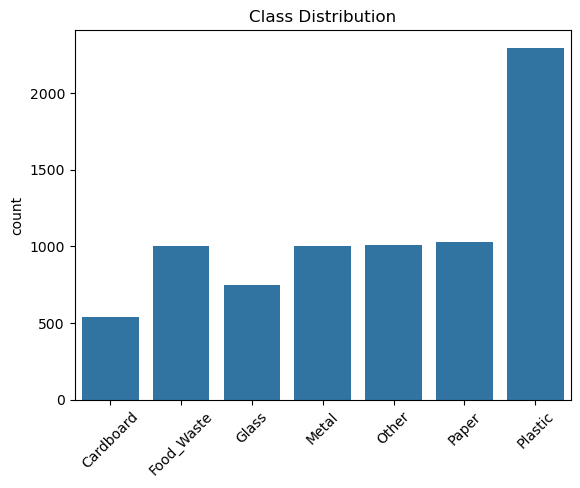

In [121]:
# Visualise Data Distribution
sns.countplot(x=labels)
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()




#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

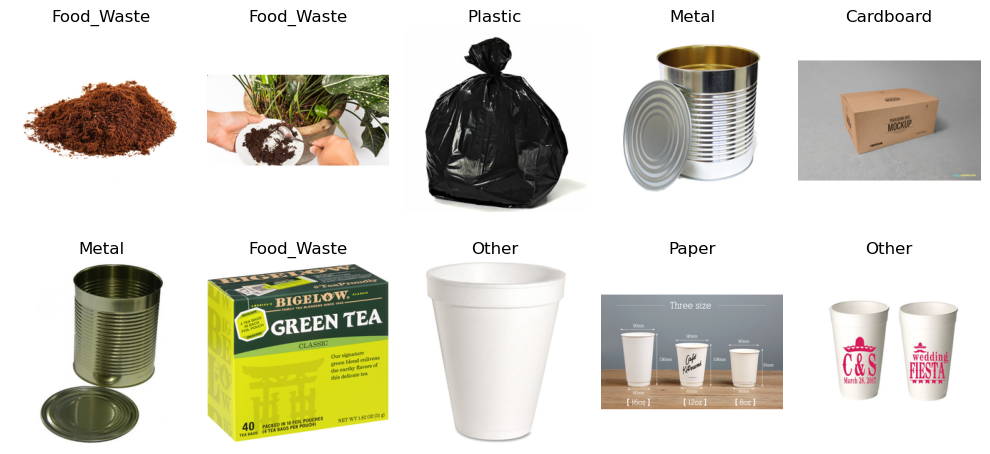

In [123]:
# Visualise Sample Images (across different labels)

def show_images(imgs, lbls):
    plt.figure(figsize=(10, 5))
    for i in range(10):
        idx = np.random.randint(0, len(imgs))
        plt.subplot(2, 5, i+1)
        plt.imshow(imgs[idx])
        plt.title(lbls[idx])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_images(images, labels)


#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [129]:
# Find the smallest and largest image dimensions from the data set

def find_image_dimension_range(root_folder):
    min_width = float('inf')
    min_height = float('inf')
    max_width = 0
    max_height = 0

    for class_folder in os.listdir(root_folder):
        class_path = os.path.join(root_folder, class_folder)
        if not os.path.isdir(class_path):
            continue
        
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                with Image.open(img_path) as img:
                    width, height = img.size
                    min_width = min(min_width, width)
                    min_height = min(min_height, height)
                    max_width = max(max_width, width)
                    max_height = max(max_height, height)
            except:
                print(f"Could not open image: {img_path}")

    return (min_width, min_height), (max_width, max_height)

# Example usage:
dataset_path = "data/data"  # Change if your dataset is in a different folder
min_dim, max_dim = find_image_dimension_range(dataset_path)

print(f"✅ Smallest dimensions: {min_dim}")
print(f"✅ Largest dimensions: {max_dim}")


✅ Smallest dimensions: (256, 256)
✅ Largest dimensions: (256, 256)


In [136]:
# Resize the image dimensions

def resize_images_to_smallest(folder, target_size):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder))

    for label in class_names:
        class_path = os.path.join(folder, label)
        if not os.path.isdir(class_path):
            continue
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                with Image.open(img_path) as img:
                    img = img.convert("RGB")
                    img = img.resize(target_size)  # (width, height)
                    images.append(np.array(img))
                    labels.append(label)
            except:
                print(f"Skipped: {img_path}")

    return np.array(images), np.array(labels), class_names

min_dim, _ = find_image_dimension_range("data/data")
min_width, min_height = min_dim  # Note: PIL uses (width, height)

# Step 2: Resize all images to smallest size
images_resized, labels, class_names = resize_images_to_smallest("data/data", (min_width, min_height))

print("✅ Resized all images to:", (min_width, min_height))
print("📦 Total images:", len(images_resized))

✅ Resized all images to: (256, 256)
📦 Total images: 7625


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [142]:
# Encode the labels suitably
# 4. Encode labels (One-hot)
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)
labels_onehot = to_categorical(labels_encoded)


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [145]:
# Assign specified parts of the dataset to train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    images / 255.0, labels_onehot, test_size=0.2, stratify=labels_encoded, random_state=42
)

augmentor = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)



## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [146]:
# Build and compile the model

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(target_size[0], target_size[1], 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [147]:
# Training
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.5)

history = model.fit(
    augmentor.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=25,
    callbacks=[early_stop, reduce_lr]
)


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 153s 790ms/step - accuracy: 0.2796 - loss: 3.1993 - val_accuracy: 0.3456 - val_loss: 1.7329 - learning_rate: 0.0010
Epoch 2/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 136s 711ms/step - accuracy: 0.3551 - loss: 1.7322 - val_accuracy: 0.3849 - val_loss: 1.6683 - learning_rate: 0.0010
Epoch 3/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 125s 650ms/step - accuracy: 0.3862 - loss: 1.6601 - val_accuracy: 0.4203 - val_loss: 1.5809 - learning_rate: 0.0010
Epoch 4/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 125s 651ms/step - accuracy: 0.4199 - loss: 1.5594 - val_accuracy: 0.4315 - val_loss: 1.5211 - learning_rate: 0.0010
Epoch 5/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 122s 636ms/step - accuracy: 0.4152 - loss: 1.5698 - val_accuracy: 0.4472 - val_loss: 1.4996 - learning_rate: 0.0010
Epoch 6/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 131s 683ms/step - accuracy: 0.4283 - loss: 1.5232 - val_accuracy: 0.4656 - val_loss: 1.4810 - learning_rate: 0.0010
Epoch 7/25
191/191 ━━━━━━━━━━━━━━━━━━━━ 126s 656ms/step - accura

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [148]:
# Evaluate on the test set; display suitable metrics

val_preds = model.predict(X_val)
y_true = np.argmax(y_val, axis=1)
y_pred = np.argmax(val_preds, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step
Classification Report:
              precision    recall  f1-score   support

   Cardboard       0.73      0.56      0.64       108
  Food_Waste       0.60      0.67      0.63       200
       Glass       0.53      0.41      0.46       150
       Metal       0.53      0.58      0.55       200
       Other       0.57      0.23      0.33       202
       Paper       0.43      0.52      0.47       206
     Plastic       0.62      0.74      0.67       459

    accuracy                           0.57      1525
   macro avg       0.57      0.53      0.54      1525
weighted avg       0.57      0.57      0.55      1525



## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images

keras.sequential()


Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images




In [ ]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


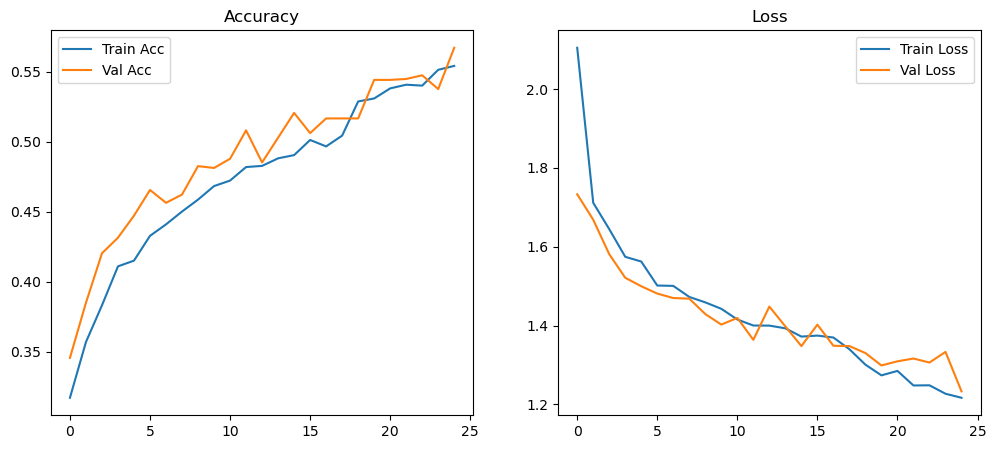

In [155]:
# Plot accuracy/loss curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()


In [157]:
# 11. Summary
print("\n✅ Model Summary:")
model.summary()



✅ Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    31,490,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 94,531,415 (360.61 MB)

 Trainable params: 31,510,471 (120.20 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,020,944 (240.41 MB)

In [159]:
print("\n📌 Key Insights:")
print("- Used one-hot encoding for multi-class targets.")
print("- Model trained with image augmentation and callbacks.")
print("- Evaluation includes precision, recall, F1-score, and confusion matrix.")
print("- Resize based on smallest image to preserve consistency.")


📌 Key Insights:
- Used one-hot encoding for multi-class targets.
- Model trained with image augmentation and callbacks.
- Evaluation includes precision, recall, F1-score, and confusion matrix.
- Resize based on smallest image to preserve consistency.
